# Imports

In [1]:
from basketball_reference_web_scraper import client
from basketball_reference_web_scraper.data import OutputType
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Concat

In [2]:
def concat(year):
    """
    Concatenates two DataFrames for adjacent seasons.

    This function reads two CSV files representing basketball data for the season and after the specified season, concatenates them along the rows, and returns a DataFrame.

    Parameters:
    -----------
    year : int
        The season in which the data for the seasons will be concatenated.

    Returns:
    --------
    pandas.DataFrame
        The concatenated DataFrame for the specified seasons.
        
    Example:
    --------
    To concatenate basketball data for the 2022-2023 season with data from the 2023-2024 season:
    >>> concat(2023)
    """
    df = pd.read_csv(f'./total/total_{year - 1}_{year}.csv')
    df_2 = pd.read_csv(f'./total/total_{year}_{year + 1}.csv')
    df_final = pd.concat([df, df_2], ignore_index=True)
    return df_final

In [3]:
#concat all of our dataframes using our function
all_data = []
for year in range(1980,2024,2):
    df_final = concat(year)
    all_data.append(df_final)
df_final = pd.concat(all_data, ignore_index = True)
df_final.to_csv('./df_final.csv', index = False)

In [4]:
df_final = pd.read_csv('./df_final.csv')

In [5]:
#name, season, and team will all be dropped before modeling. Additionally, no null values so we will need to encode predicted variable and change all of them to int.
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18788 entries, 0 to 18787
Data columns (total 76 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   name                               18788 non-null  object 
 1   mpg                                18788 non-null  float64
 2   fgm_per_g                          18788 non-null  float64
 3   fga_per_g                          18788 non-null  float64
 4   fg_pct                             18788 non-null  float64
 5   fg3m_per_g                         18788 non-null  float64
 6   fg3a_per_g                         18788 non-null  float64
 7   fg3_pct                            18788 non-null  float64
 8   fg2m_per_g                         18788 non-null  float64
 9   fg2a_per_g                         18788 non-null  float64
 10  fg2_pct                            18788 non-null  float64
 11  efg_pct                            18788 non-null  flo

In [6]:
#change all target columns to integers
award_columns = df_final.columns[-7:]
for award in award_columns:
    df_final[award] = df_final[award].astype(int)

In [7]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18788 entries, 0 to 18787
Data columns (total 76 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   name                               18788 non-null  object 
 1   mpg                                18788 non-null  float64
 2   fgm_per_g                          18788 non-null  float64
 3   fga_per_g                          18788 non-null  float64
 4   fg_pct                             18788 non-null  float64
 5   fg3m_per_g                         18788 non-null  float64
 6   fg3a_per_g                         18788 non-null  float64
 7   fg3_pct                            18788 non-null  float64
 8   fg2m_per_g                         18788 non-null  float64
 9   fg2a_per_g                         18788 non-null  float64
 10  fg2_pct                            18788 non-null  float64
 11  efg_pct                            18788 non-null  flo

In [8]:
#relabel target columns the names of the columns to label encode them
for award in list(award_columns):
    df_final[award] = df_final[award].apply(lambda x: award if x == 1 else None)
# add a new column 'target' that is a string of all the awards
df_final['target'] = df_final[list(award_columns)].apply(lambda x: ', '.join(x.dropna().astype(str)), axis = 1)

In [9]:
#fill in the empty strings with 0
df_final['target'] = df_final['target'].replace('', 'no_award')

In [10]:
#check the value_counts
df_final['target'].value_counts()

target
no_award          18089
team_2nd            207
team_1st            166
team_3rd            162
MVP, team_1st        44
SMOY                 40
MIP                  28
DPOY, team_1st       13
DPOY                 12
DPOY, team_2nd        8
DPOY, team_3rd        8
MIP, team_2nd         6
MIP, team_3rd         4
SMOY, team_3rd        1
Name: count, dtype: int64

In [11]:
#going to get rid of everything but the all_nba teams. all of the other awards have too small of a class to predict
df_final.drop(columns = ['MVP', 'SMOY', 'MIP', 'DPOY', 'MIP', 'target'], inplace = True)

In [12]:
award_columns = ['team_1st', 'team_2nd', 'team_3rd']

In [13]:
# add a new column 'target' that is a string of all the awards
df_final['target'] = df_final[award_columns].apply(lambda x: ', '.join(x.dropna().astype(str)), axis = 1)
#fill in the empty strings with 0
df_final['target'] = df_final['target'].replace('', 'no_award')

In [14]:
#check the value_counts
df_final['target'].value_counts()

target
no_award    18169
team_1st      223
team_2nd      221
team_3rd      175
Name: count, dtype: int64

# Label Encode

In [15]:
le = LabelEncoder()
df_final['target_encoded'] = le.fit_transform(df_final['target'])

In [16]:
#label classes
le.classes_

array(['no_award', 'team_1st', 'team_2nd', 'team_3rd'], dtype=object)

In [17]:
#dropping extra columns for data analysis
df_final.drop(columns = award_columns, inplace = True)
df_final.drop(columns = ['season', 'team', 'name', 'target'], inplace = True)
#dropping positions as all_nba is now positionless
df_final.drop(columns = ['positions_Center', 'positions_Point Guard', 'positions_Power Forward', 'positions_Shooting Guard', 'positions_Small Forward'], inplace = True)

In [18]:
df_final['target_encoded'].value_counts()

target_encoded
0    18169
1      223
2      221
3      175
Name: count, dtype: int64

# Coorelations

In [19]:
corr = df_final.corr(numeric_only = True)[['target_encoded']].sort_values(by = 'target_encoded', ascending = False) 
corr

,target_encoded
target_encoded,1.000000
value_over_replacement_player,0.514838
win_shares,0.453894
offensive_win_shares,0.452752
made_free_throws,0.424688
...,...
block_percentage,0.041161
age,0.032039
offensive_rebound_percentage,0.005737
three_point_attempt_rate,-0.034403


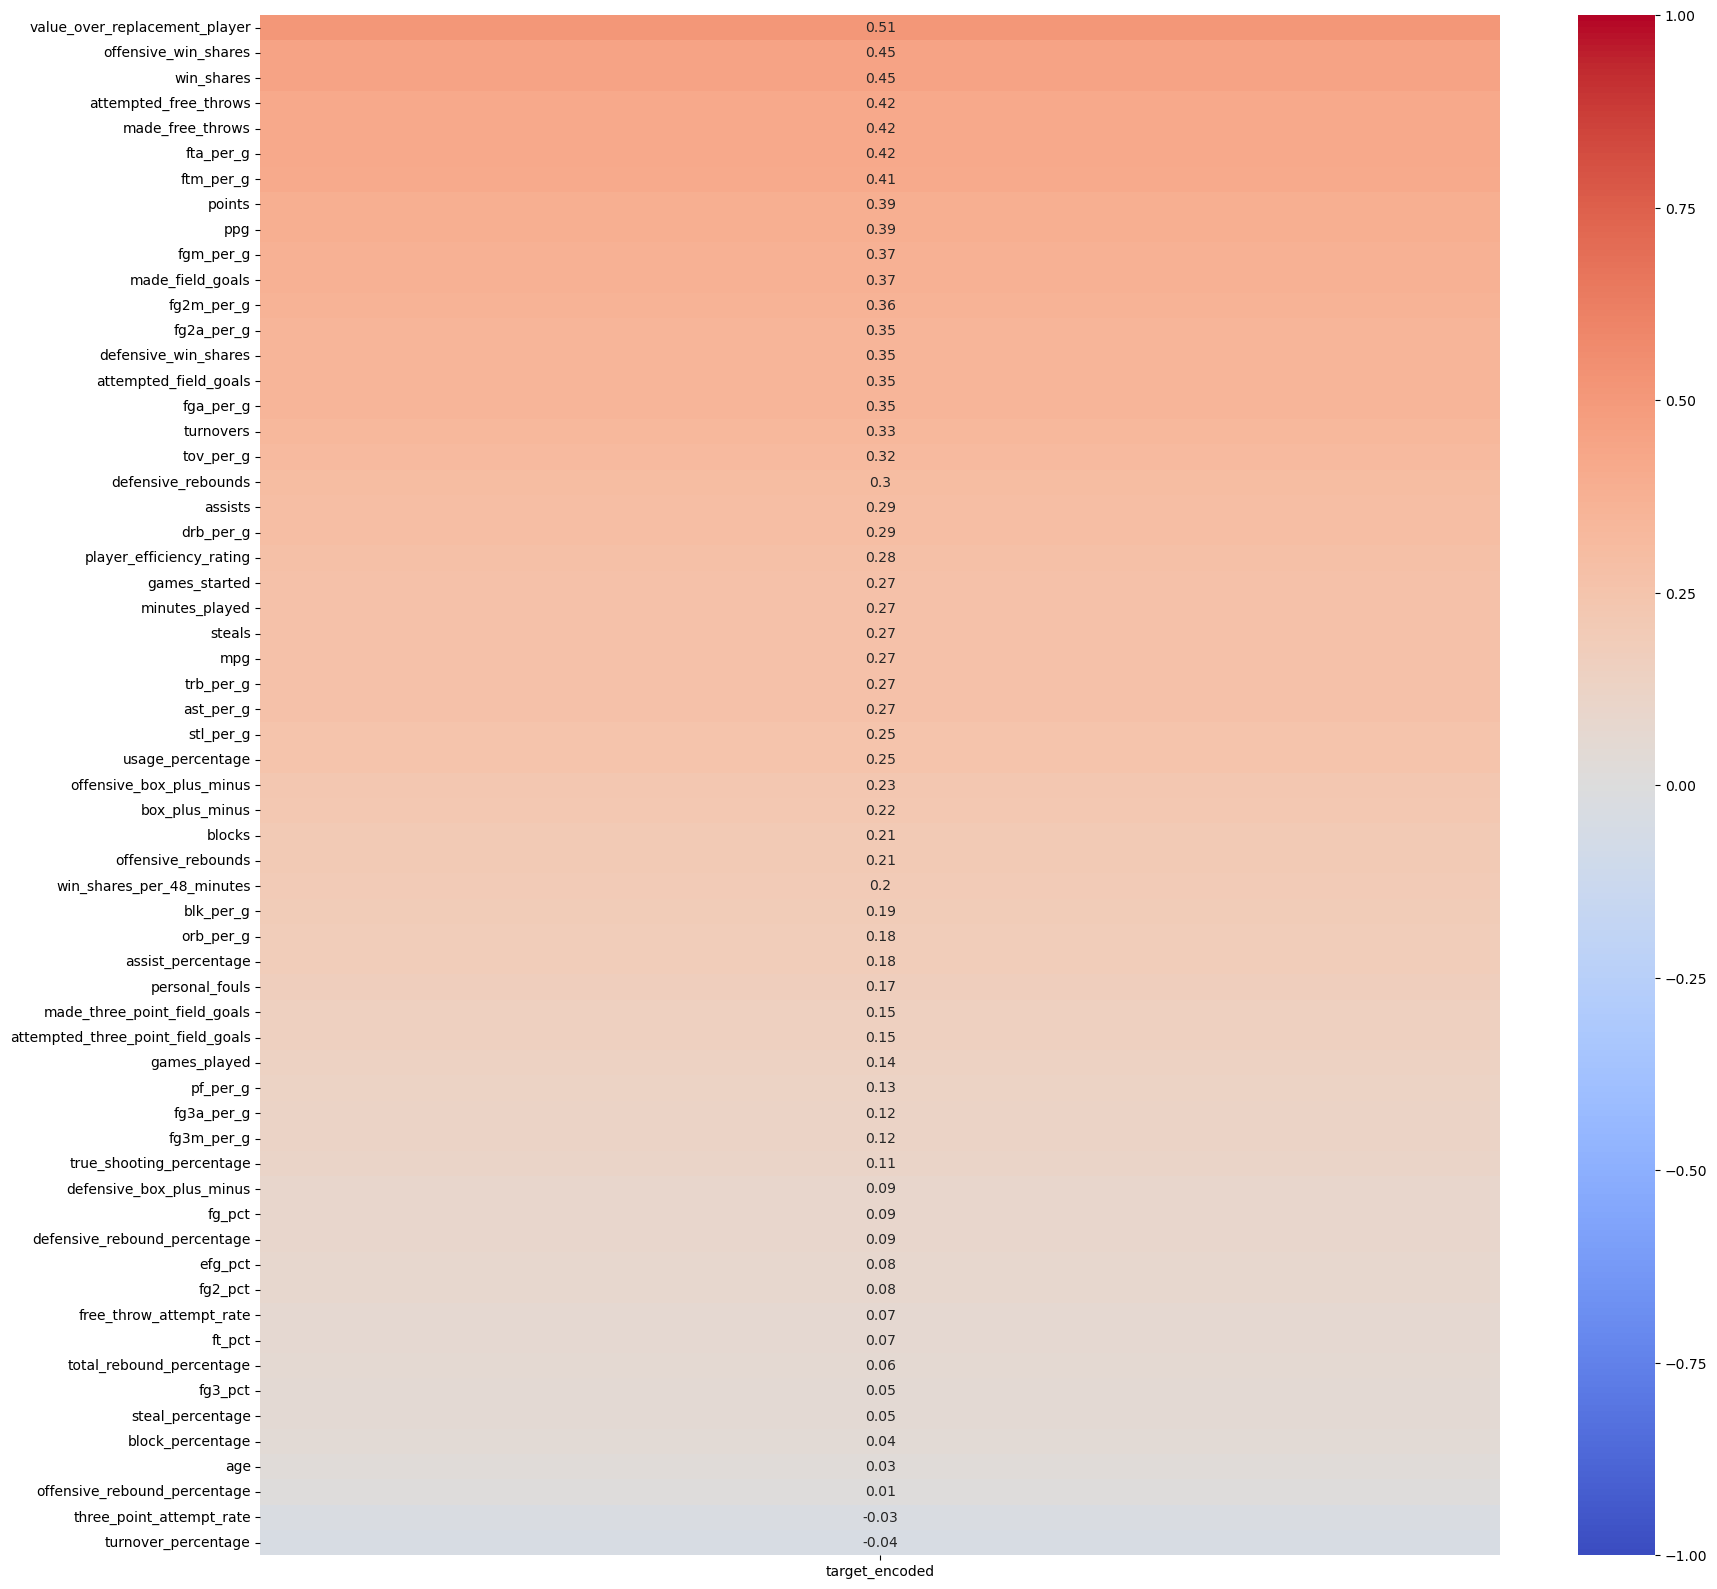

In [20]:
plt.figure(figsize=(20, 20))
corr = round(df_final.corr(numeric_only = True), 2)
target_corr = corr[['target_encoded']].drop('target_encoded').sort_values(by='target_encoded', ascending=False)
sns.heatmap(target_corr,
            vmin = -1,
            vmax = 1,
           annot = True,
            cmap = 'coolwarm'
           );

In [21]:
df_final.to_csv('./df_final.csv', index = False)